# Assignment #1
### Exploratory Data Analysis

#### In this assignment, we will investigate relationships in covid severity using bulk RNA-seq data.

The data we will look at is from a large scale multi-omic analysis of COVID severity published in early 2021. This means that this dataset used many -omics techniologies (transcriptomics, proteomics, metabolomics, etc.) to investigate biomarkers associated with COVID-19 status and severity. For this assignment, we're specifically going to look at RNA-seq data collected from plasma and leukocyte samples.

In this assignment, we'll do an exploratory data analysis to try to find some interesting biological conclusions about how gene expression in cells change in response to COVID19!

Read the paper to learn more about the study [here](https://www.sciencedirect.com/science/article/pii/S2405471220303719?via%3Dihub#appsec2). The data is located [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE157103) (data is already included in the zip file, so don't worry about downloading it from there).


#### First, let's load in our packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# You may need to edit this line if you can't load the dataset
# os.chdir('/Users/vishal/Documents/TA_Class/assignments/Assignment1/')

#### And then, our data

In [2]:
# First, we load our RNA counts table
counts=pd.read_table('./GSE157103_genes.tpm.tsv', sep='\t')
# Next, let's do some preprocessing for convenience
counts = counts.rename(columns={'#symbol': 'sampleID'})
counts = counts.set_index('sampleID').T
# Now, let's look at the first 5 rows
counts.head()

sampleID,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
C1,0.49,0.00,0.21,0.04,0.07,0.0,0.03,18.92,4.07,0.0,...,2.84,4.22,0.95,1.63,15.51,0.06,8.17,363.01,19.17,6.05
C2,0.29,0.00,0.14,0.00,0.00,0.0,0.05,18.68,3.00,0.0,...,3.55,12.15,0.60,1.15,15.62,0.14,8.20,399.80,15.72,4.12
C3,0.26,0.00,0.03,0.02,0.00,0.0,0.07,13.85,1.83,0.0,...,1.34,2.79,0.18,0.32,17.67,0.28,3.62,430.35,13.95,1.81
C4,0.45,0.01,0.09,0.07,0.00,0.0,0.00,22.11,4.22,0.0,...,3.71,5.87,1.40,2.21,15.61,0.27,7.88,209.25,14.78,7.15
C5,0.17,0.00,0.00,0.05,0.07,0.0,0.00,8.45,1.17,0.0,...,1.44,4.46,0.28,0.55,9.34,0.07,5.96,272.91,8.69,2.70


In [3]:
# Next, we can load our metadata file
# This will contain various characteristics about each sample
metadata = pd.read_table('./GSE157103_metadata.csv', sep=',')
# Now, some preprocessing
del metadata['Unnamed: 0']
metadata = metadata.set_index('sampleID')
metadata['age'][metadata['age'] == ':'] = np.nan
metadata['age'] = metadata['age'].astype('float')
# And now let's look at the first 5 rows
metadata.head()

,age,sex,hospital,covid
sampleID,,,,
C1,39.0,male,NonICU,COVID
C2,63.0,male,NonICU,COVID
C3,33.0,male,NonICU,COVID
C4,49.0,male,NonICU,COVID
C5,49.0,male,NonICU,COVID


## 1: Preprocessing

First, we're going to take a look at our dataset and get it ready for our analysis.

#### a) Overview of the Data

1. Read a little about the study and the dataset. What kind of tissue is our data from? What information does the `counts` dataframe contain? What information does the `metadata` dataframe contain? What do the rows and columns represent in each of these dataframes?

The study and dataset focus on analyzing RNA-seq and high-resolution mass spectrometry data from blood samples of COVID-19-positive and negative patients to identify molecular features associated with the disease's status and severity. The data is derived from blood plasma and leukocytes, aiming to uncover biomarkers and the systemic effects of COVID-19 on gene expression, protein, metabolite, and lipid levels. The 'counts' dataframe contains transcriptomic data, specifically gene expression levels measured in transcripts per million (TPM) from leukocyte samples. The metadata dataframe provides sample characteristics, including patient IDs, COVID- 19 status, age, gender, and other clinical information. Rows in the counts dataframe represent different genes, while columns represent samples. In the metadata dataframe, rows correspond to samples, and columns contain metadata attributes.

2. How many samples do we have? How many genes?

The dataset comprises 126 samples and 19,472 genes. The counts dataframe, containing RNA-seq data, shows gene expression levels across 126 samples (patients) for 19,472 genes. The metadata dataframe, which provides various characteristics for each sample, including COVID-19 status, age, and other clinical information, also includes 126 samples with details spread across 5 columns (after preprocessing steps).

#### b) Filtering Data
1. When we do RNA-seq analysis, we end up with a lot of genes that have very low expression and need to be filtered out. Filter the `counts` dataframe to only contain genes that have non-zero expression in at least 10% of samples. In other words, if a gene has an expression of zero in more than 12 samples, remove that gene.

In [4]:
# Filter genes here

# Determine the number of samples in which a gene must be expressed to meet the 10% criterion
required_non_zero_samples = counts.shape[0] * 0.10

# Filter the 'counts' dataframe to only include genes with non-zero expression in at least 10% of samples
filtered_counts = counts.loc[:, (counts > 0).sum(axis=0) >= required_non_zero_samples]

filtered_counts.shape


(126, 16765)

2. How many genes did we filter out?

In [5]:
# Calculate the number of genes filtered out
genes_initial = counts.shape[1]
genes_filtered = filtered_counts.shape[1]
genes_removed = genes_initial - genes_filtered

genes_removed


2707

We filtered out 2,707 genes due to very low expression across the samples.

**NOTE: Use this filtered dataset for the remaining analysis.**

#### c) Data Normalization

1. This data is already normalized for us. How has the data been normalized? (hint, look at the filenames).

The filename `GSE157103_genes.tpm.tsv` indicates that the data has been normalized using the Transcripts Per Million (TPM) method, which is a normalization technique used in RNA sequencing data analysis to control for both gene length and sequencing depth across samples.

2. Sum up the transcripts for each sample in the data. What do these numbers add up to? How does this confirm our answer from the previous question?

In [6]:
# Sum transcripts here

# Sum up the transcripts for each sample in the filtered data
sample_sums = filtered_counts.sum(axis=1)

# Display the sum for each sample
sample_sums.head(), sample_sums.mean()


(C1    999994.70
 C2    999997.25
 C3    999938.98
 C4    999992.58
 C5    999998.42
 dtype: float64,
 999992.4773015872)

The sums of transcripts for each sample in the filtered dataset are very close to 1,000,000. This result confirms that the data has been normalized using the TPM method, because the sum of all transcript values in a sample is scaled to nearly equal one million, allowing for direct comparisons of transcript levels between samples.

3. Why are each of these sample sums slightly different from what we would expect?

There are perhaps two reasons to this. One is the rounding erros, as the process of normalizing data and converting to TPM involves division and multiplication by scaling factors that can introduce rounding errors, especoially when dealing with faloting-point arithmetic. And these errors can accumulate up acorss thousands of genes, leading to slight deviations in the final sums./

The second reason might be filtering of genes we previously did. Since we filtered out genes with very low expressions, the total sum of TPM values might slightly deviate from 1,000,000. And so the removal of these genes means that the remaining TPM values must be recalculated or rescaled in a sense, that can alter the total sum due to the exclusion of these low-expression values.

## 2: Principal Component Analysis

Our data is so big! There are tens of thousands of features! In order to visualize our data, we'll use PCA for dimensionality reduction. This will allow us to explore trends in our data.

#### a) Perform Principal Component Analysis
1. Perform principal component analysis over samples (use code from class or a package like scikit-learn). Print the first few rows of your computed PCs. What do the rows represent in this matrix? What do the columns represent?

In [7]:
# DO PCA HERE

from sklearn.decomposition import PCA

# Initialize PCA, specifying the number of components to compute
pca = PCA(n_components=10)  # Compute the first 10 components as an example

# Perform PCA on the filtered counts data
pca_result = pca.fit_transform(filtered_counts)

# Convert PCA result to a DataFrame for better readability
pca_df = pd.DataFrame(pca_result, index=filtered_counts.index,
                      columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])



In [8]:
# PRINT FIRST FEW ROWS OF PCs

# Display the first few rows of the PCA result
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
C1,-39217.007110,-49928.804723,-6779.457481,-354.334581,-4584.773915,-11808.191327,-2798.590561,3030.599296,9597.926286,-7337.685812
C2,-34127.521463,-42936.200794,18526.205558,6423.453927,-2490.930864,-4925.256625,-2102.129648,-1806.216022,3351.022349,-5899.637546
C3,-62908.082630,-9761.417594,-11473.629940,-23446.754923,-17826.791059,-11388.973542,-2689.626260,8285.785279,2708.523667,3825.386424
C4,3387.927957,-80875.718214,-4289.267211,12890.019282,6170.605000,-9283.927353,-3650.468662,-2702.272699,-38.074466,-1222.428724
C5,-67812.511721,26973.370308,-18533.312262,16223.312113,-9680.761540,-5564.328363,3729.163224,12155.685698,-9881.077286,767.407753


*ANSWER HERE*

Rows represent the individual samples. And columns represent the principal components, which are some orthogonal vectors that capture the directions of maximum variance in our data. 'PC1' would captures the most variance, 'PC2' captures the second most, and so on.


2. Now, we can plot the data on the axes of greatest variation in our data (i.e. the principal components). That way, we can visualize the data instead of having to look at 20,000 dimensions. Display a scatterplot of the first 2 principal components. Your plot should display each sample as a dot on a grid with axes PC1 and PC2.

/var/folders/zk/wg0rx4b968n669r91ch1ymv40000gn/T/ipykernel_63219/3173655075.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=50, palette='viridis')


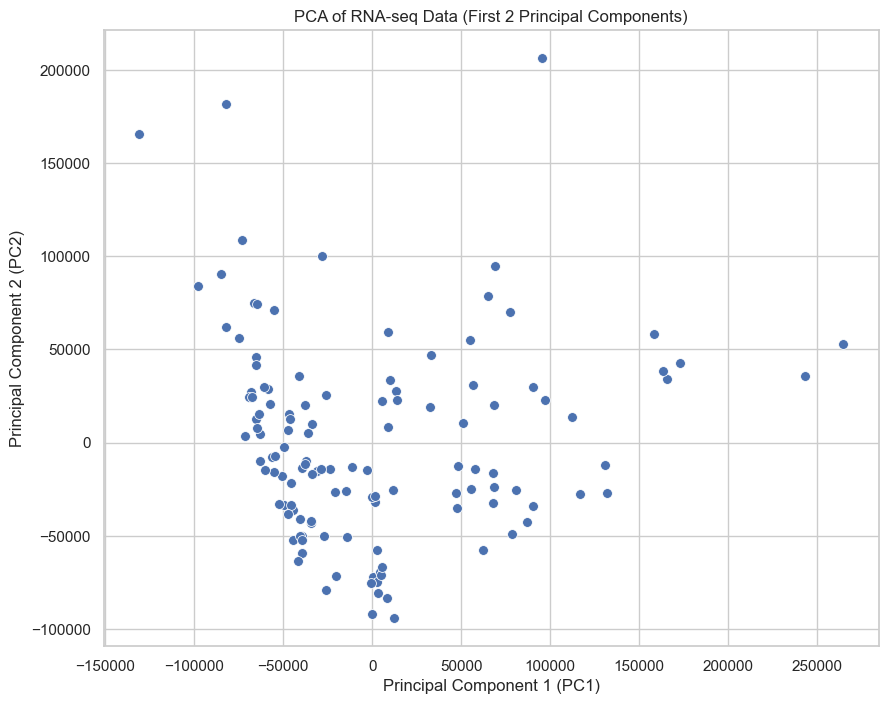

In [9]:
# PLOT PCs HERE

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=50, palette='viridis')
plt.title('PCA of RNA-seq Data (First 2 Principal Components)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()

3. What do you see (qualitatively)? Is there any visible clustering of samples? How are the samples distributed along PC1 and PC2?

- The sanples appear to be distributed mostly along PC1. And there is wide spread of data points, which means PC1 captures a significant proportion of the variance in the data.
- There are regions where the density of samples is higher, suggesting potential subgroups within the data.
- Along PC2, the vertical axis, the samples also show some degree of spread, but it is less pronounced compared to PC1. This suggests that PC2 captures less variance in the data than PC1.
- There seem to be some samples that are quite far away from the main density of points, especially along PC1, which could be outliers or samples with a distinct gene expression profile.

4. Now that we have principal components, we want to understand how much of the variance in the data is explained by each PC. This will help us understand what each PC represents. Create a plot of variance explained by the first 10 principal components. Comment on any trends you see.

   We want a plot that looks like this (with different numbers):

   <img src="./pve.png" alt="pve" width="300"/>


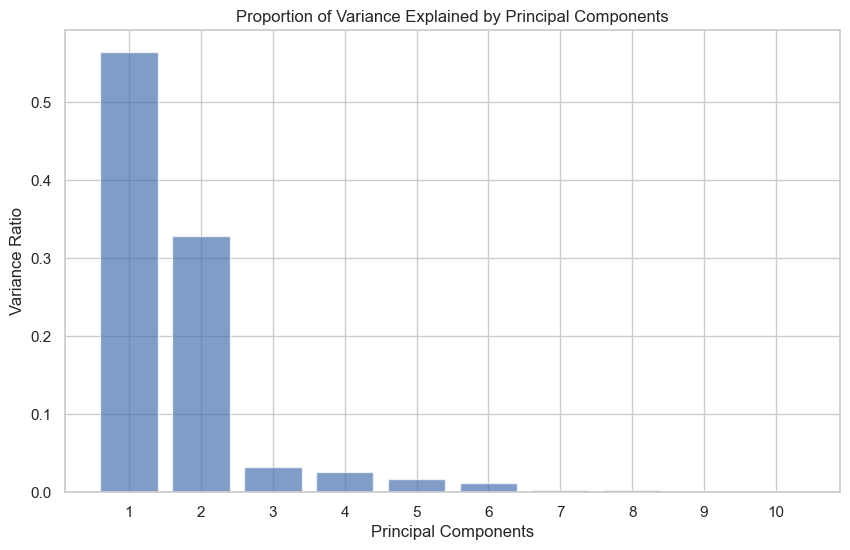

In [10]:
# PLOT PVE HERE

# Perform PCA with 10 components
pca_10 = PCA(n_components=10)
pca_10_result = pca_10.fit(filtered_counts)

# Variance explained by each of the 10 principal components
explained_variance = pca_10.explained_variance_ratio_

# Create a bar plot for the variance explained by the first 10 principal components
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.title('Proportion of Variance Explained by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()

*ANSWER HERE*

From the output, we can see the following:

- The first principal component explains a significant portion of the variance in the data, which indicates that PC1 captures the most dominant pattern across the samples
- We can also see there is a rapid decline, from PC1 to PC2 in terms of the variance ratio, and then from PC2 onward, each subsequent principla component explains progressively less of the variance
- Afer the initial few components, the amount of variance explained by each component levels off, which in some way that shows us that beyond a certain level or "point", additional components do not capture substantial new info about the data

5. Lets investigate what seems to be driving PC1 and PC2. Which genes are most highly associated with the first 4 principal components? The loadings for genes are in the `U` variable from `our_pca()` function. We want four plots that look like this:
   
   <img src="./loadings.png" alt="load" width="300"/>

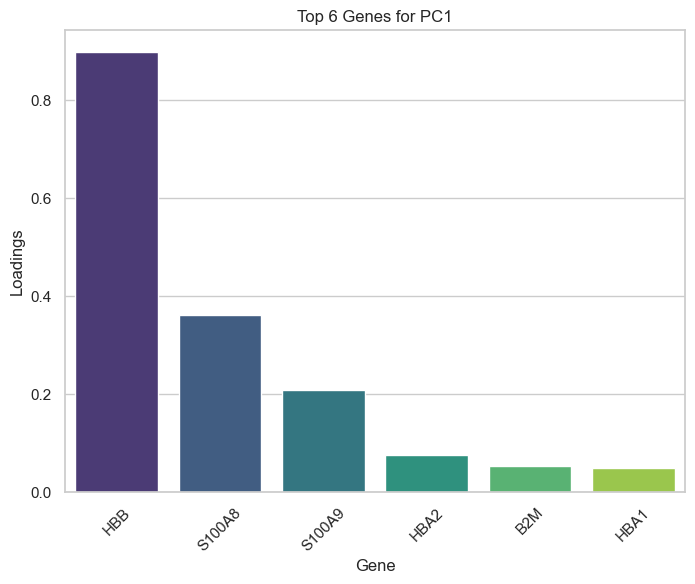

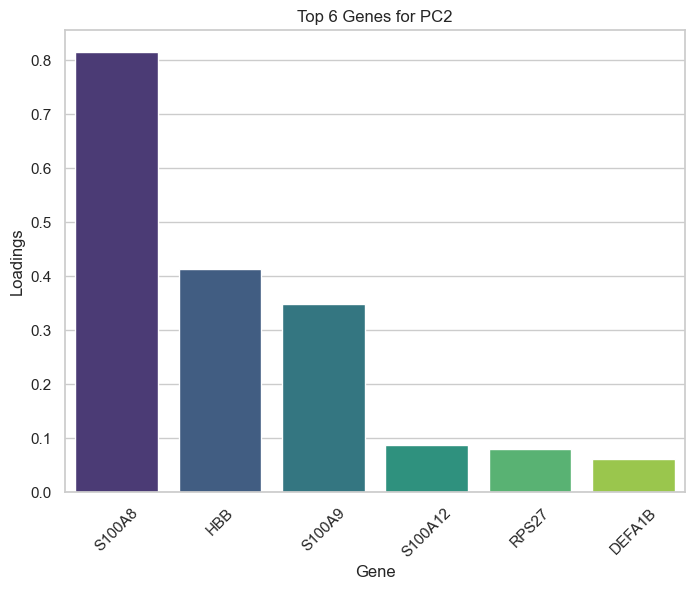

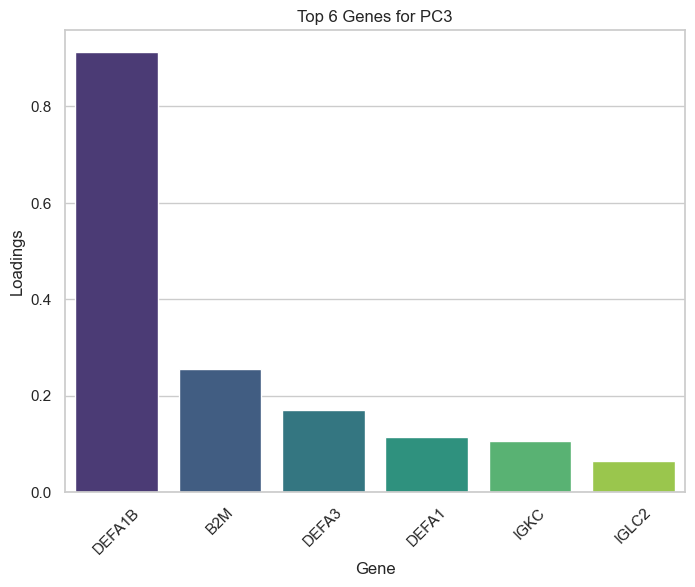

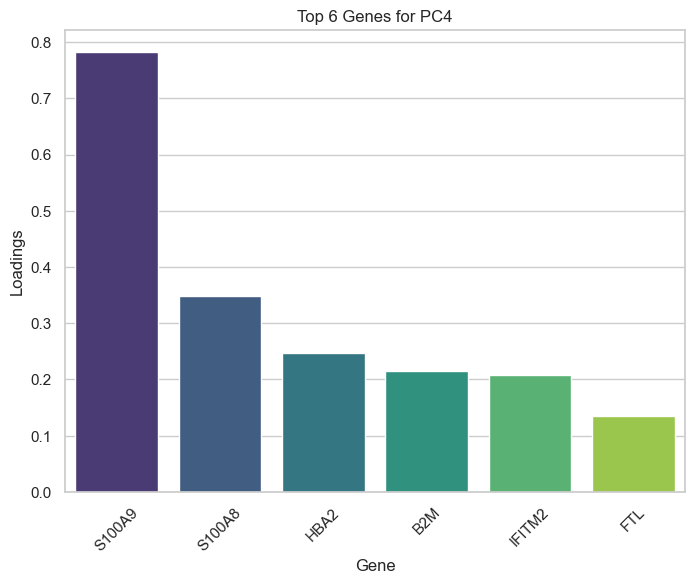

In [11]:
# PLOT LOADINGS HERE

pca_4 = PCA(n_components=4)
pca_4_result = pca_4.fit(filtered_counts)

# Get the loadings for the first 4 principal components
loadings = pca_4.components_.T

# Convert loadings into a DataFrame
loadings_df = pd.DataFrame(loadings, index=filtered_counts.columns, 
                           columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Number of top features to select for each principal component
top_features = 6

# Loop through each principal component to create vertical bar plots
for i in range(4):
    # Extract the top genes for the current principal component based on absolute loadings
    sorted_loadings = loadings_df.iloc[:, i].abs().sort_values(ascending=False)[:top_features]
    top_genes_names = sorted_loadings.index

    # Create the bar plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_genes_names, y=sorted_loadings.values, palette='viridis')
    plt.title(f'Top {top_features} Genes for PC{i+1}')
    plt.ylabel('Loadings')
    plt.xlabel('Gene')
    plt.xticks(rotation=45)
    plt.show()


6. There definitiely seems to be one gene that is mostly driving PC1. What gene is it? What is this gene? What is its role? What types of cells tend to express this gene.

*ANSWER HERE*

The gene that appears to be mostly driving PC1 is HBB, which is Hemoglobin subunit beta. This gene is responsible for encoding one of the two types of polypeptide chains that form hemoglobin, the protein in red blood cells that carries oxygen from the lungs to the rest of the body. Mutations in the HBB gene are associated with various disorders, including sickle cell anemia and beta-thalassemia.

HBB is expressed predominantly in red blood cells and the precursors of erythrocytes in the bone marrow. The role of HBB is crucial for oxygen transport, and its expression is a signature of red blood cell function and development. Also, high expression of HBB in the context of COVID-19 could suggest an impact of the virus on oxygen transport or red blood cell dynamics.

Reference:

1. Piel, F. B., Patil, A. P., Howes, R. E., Nyangiri, O. A., Gething, P. W., Williams, T. N., Weatherall, D. J., & Hay, S. I. (2010). Global distribution of the sickle cell gene and geographical confirmation of the malaria hypothesis. Nature Communications, 1, 104. https://doi.org/10.1038/ncomms1104.
2. Weatherall, D. J. (2001). Phenotype-genotype relationships in monogenic disease: lessons from the thalassaemias. Nature Reviews Genetics, 2(4), 245-255. https://doi.org/10.1038/35066048.

In [12]:
# Some code to verity this

# Perform PCA with 4 components
pca_4 = PCA(n_components=4)
pca_4_result = pca_4.fit(filtered_counts)

# Get the loadings for the first 4 principal components
loadings = pca_4.components_.T

# Convert loadings into a DataFrame
loadings_df = pd.DataFrame(loadings, index=filtered_counts.columns, 
                           columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Retrieve the top gene for PC1 based on its loading
top_gene_PC1 = loadings_df['PC1'].abs().idxmax()

top_gene_PC1, loadings_df.loc[top_gene_PC1]

('HBB',
 PC1    0.898819
 PC2    0.414025
 PC3   -0.033763
 PC4   -0.000407
 Name: HBB, dtype: float64)

7. Recall that these samples are from plasma and leukocyte samples from patients. Knowing this, why do you think that this gene has such a high influence on our PCs? Why is this not something we want?

*ANSWER HERE*

This could indicate that there is a substantial presence of red blood ceel or hemoglobin components within the samples, which could be due to hemolysis or contamination during sample collection or processing, where RBCs are lysed, and their content are released into the plasma.

We might not like this because the significant influence of HBB would suggests that the samples maybe contaminated with intracellular contents from red blood cells, which can confound the analysis of leukocyte gene expression profiles. Additionally, the overwhelming signal from HBB could mask the expression patterns of other genes of interest, particularly those relevant to the immune response or the pathophysiology of COVID 19 in leukocytes.

It could also lead to some misinterpretations of the data.

Reference:
1. Reisz, J. A., Wither, M. J., Dzieciatkowska, M., Nemkov, T., Issaian, A., Yoshida, T., ... & Hansen, K. C. (2016). Oxidative modifications of glyceraldehyde 3-phosphate dehydrogenase regulate metabolic reprogramming of stored red blood cells. Blood, The Journal of the American Society of Hematology, 128(12), e32-e42. https://doi.org/10.1182/blood-2016-05-714816.
2. Lippi, G., Chance, J. J., Church, S., Dazzi, P., Fontana, R., Giavarina, D., & Grankvist, K. (2011). Preanalytical quality improvement: from dream to reality. Clinical Chemistry and Laboratory Medicine (CCLM), 49(7), 1113-1126. https://doi.org/10.1515/CCLM.2011.600.


8. Because PC1 is primarily driven by this unwanted observation, and does not appear to contain information on the biology we're after, generate a data matrix with PC1 removed.

   One way to do this is to first, take the formulation of the singular value decomposition X = UDV<sup>T</sup>. Now, compute X again where you set the singular value for PC1 to zero. In other words, set the first (and largest) value in D to zero and recompute the product. (D can also be notated as sigma)

   Another way to do this is to look at the function from class. This function returns U and DV<sup>T</sup> (DV<sup>T</sup> is named PCs in the function). So, remove the first column in U, and the first row in DV<sup>T</sup>. Then compute the product.

   At the end of this, you should have a representation of the data with PC1 removed.

In [13]:
# REMOVE PC1 HERE

# Perform SVD on the filtered data
U, S, VT = np.linalg.svd(filtered_counts, full_matrices=False)

# Set the first singular value in S to zero to remove the effect of PC1
S[0] = 0

# Recompute the data matrix with PC1 removed
D = np.diag(S)
X_new = np.dot(U, np.dot(D, VT))

# Convert the new data matrix to a DataFrame for convenience
counts_with_PC1_removed = pd.DataFrame(X_new, index=filtered_counts.index, columns=filtered_counts.columns)

counts_with_PC1_removed.head()


sampleID,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADACL2,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
C1,0.304282,-0.001048,0.145595,0.032689,-0.000107,-0.013529,0.022315,10.455813,2.866713,-0.001028,...,1.764418,1.174413,0.741962,1.130796,8.184403,-0.024328,5.370493,139.104101,14.232671,4.535256
C2,0.090085,-0.001128,0.070671,-0.007870,-0.075466,-0.014563,0.041728,9.568787,1.704731,-0.001106,...,2.392197,8.871600,0.376059,0.612636,7.734414,0.049226,5.186491,158.778119,10.405248,2.489465
C3,-0.010003,-0.001524,-0.063635,0.009371,-0.101924,-0.019669,0.058828,1.544457,0.080618,-0.001494,...,-0.223721,-1.637785,-0.122454,-0.405760,7.019780,0.157401,-0.450025,104.827452,6.771931,-0.392190
C4,0.315859,0.009243,0.043481,0.064719,-0.050637,-0.009772,-0.005550,15.996456,3.350886,-0.000742,...,2.933125,3.670223,1.249737,1.849433,10.318841,0.209091,5.857962,47.526433,11.213848,6.055925
C5,-0.161534,-0.001871,-0.114973,0.036949,-0.055151,-0.024151,-0.013718,-6.659823,-0.978044,-0.001835,...,-0.480073,-0.976822,-0.091379,-0.341152,-3.737272,-0.080538,0.962467,-126.795073,-0.123861,-0.004042


9. Regenerate your scatterplot of PC1 and PC2, your proportion variance explained plot, and your gene loadings for the first 4 PCs. Has anything changed? What are the functions of the new most influential genes? Why is this better than before?

/var/folders/zk/wg0rx4b968n669r91ch1ymv40000gn/T/ipykernel_63219/2995106088.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PC1', y='PC2', data=pca_after_removal_df, s=50, palette='viridis')


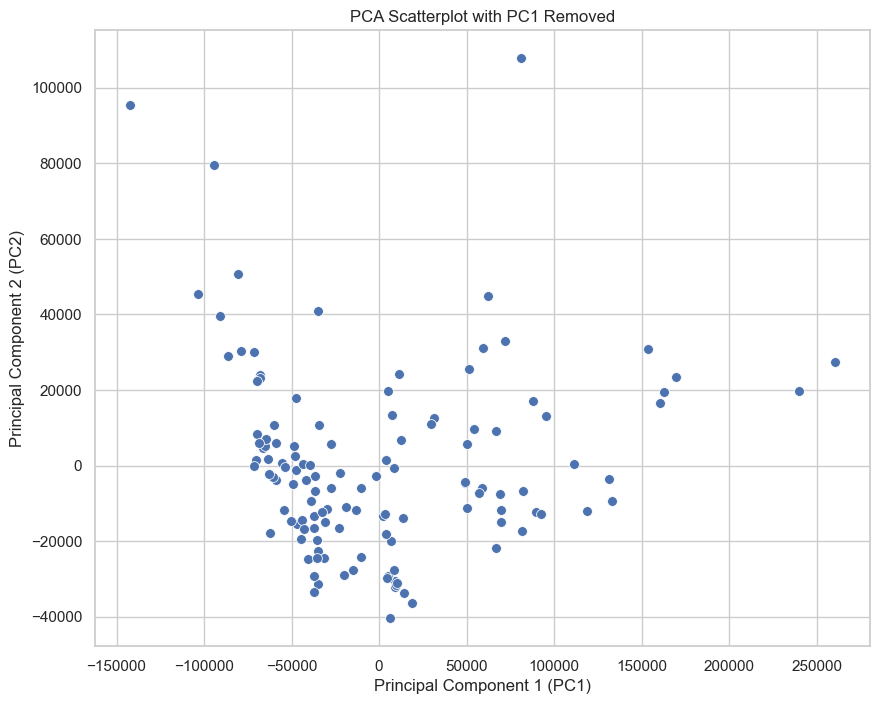

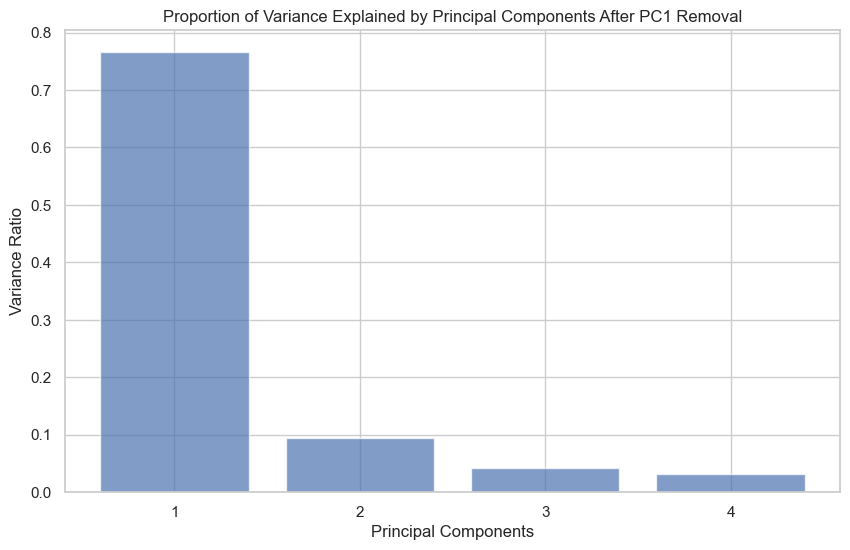

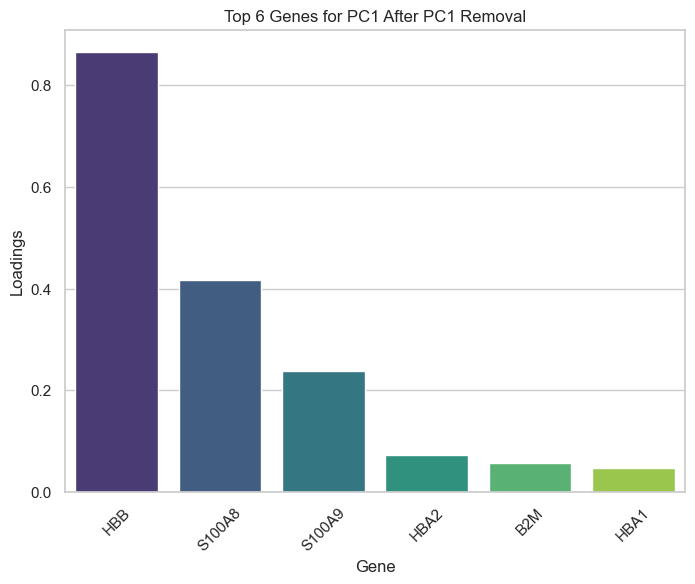

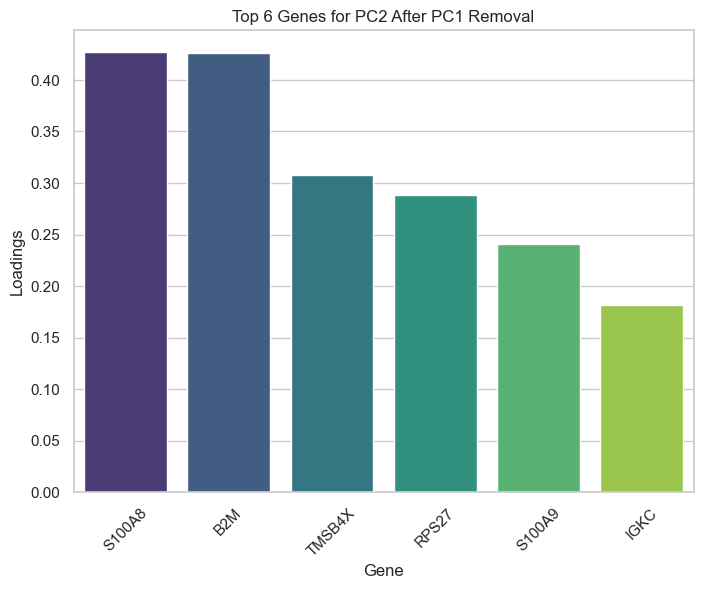

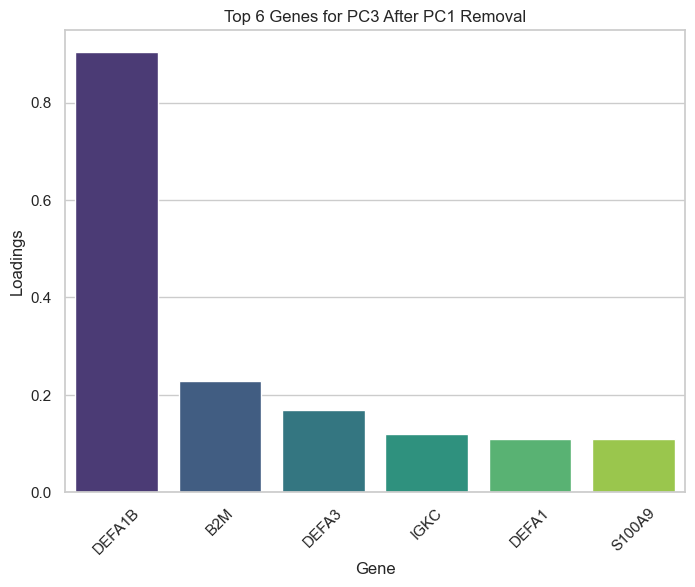

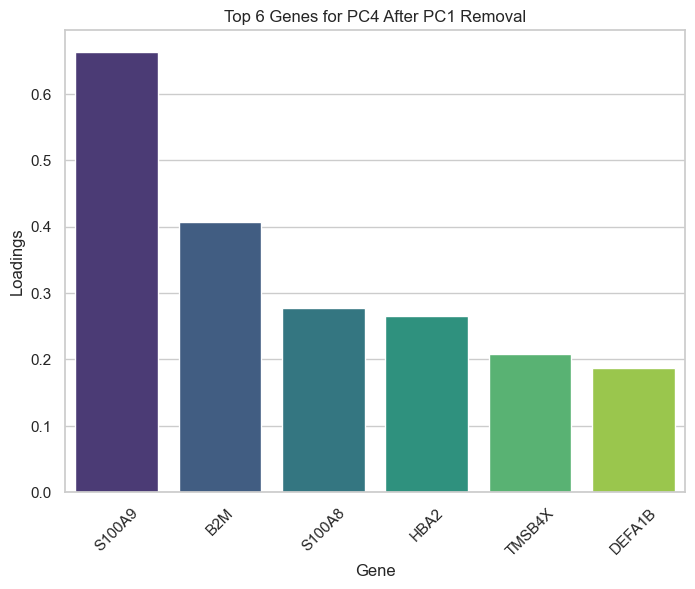

In [14]:
# PLOT HERE

# Perform PCA on the new data matrix with PC1 removed
pca_after_removal = PCA(n_components=4)
pca_after_removal_result = pca_after_removal.fit(counts_with_PC1_removed)

# Compute the new principal components
PCs_after_removal = pca_after_removal.transform(counts_with_PC1_removed)
pca_after_removal_df = pd.DataFrame(PCs_after_removal, index=filtered_counts.index,
                                    columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Plot the new scatterplot of PC1 and PC2
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_after_removal_df, s=50, palette='viridis')
plt.title('PCA Scatterplot with PC1 Removed')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()

# Plot the new proportion variance explained
explained_variance_after_removal = pca_after_removal.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_after_removal) + 1), explained_variance_after_removal, alpha=0.7)
plt.title('Proportion of Variance Explained by Principal Components After PC1 Removal')
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.xticks(range(1, len(explained_variance_after_removal) + 1))
plt.show()

# Get the loadings for the first 4 principal components after PC1 removal
loadings_after_removal = pca_after_removal.components_.T
loadings_after_removal_df = pd.DataFrame(loadings_after_removal, index=filtered_counts.columns,
                                         columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Plot the new gene loadings for the first 4 PCs
for i in range(4):
    sorted_loadings_after_removal = loadings_after_removal_df.iloc[:, i].abs().sort_values(ascending=False)[:top_features]
    top_genes_names_after_removal = sorted_loadings_after_removal.index
    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_genes_names_after_removal, y=sorted_loadings_after_removal.values, palette='viridis')
    plt.title(f'Top {top_features} Genes for PC{i+1} After PC1 Removal')
    plt.ylabel('Loadings')
    plt.xlabel('Gene')
    plt.xticks(rotation=45)
    plt.show()


*ANSWER HERE*

We can see from the new plots that there are some changes. The scatterplot now reflects variations along what were originally the second and third principal components, which may present a more accurate representation of the underlying biological variance in the absence of the HBB influence. Also, the proportion of variance explained by each component has shifted, with the new PC1 explaining less variance than the original PC1 dominated by HBB. Last, the gene loadings for the first four PCs have changed, showing different genes as the most influential. The top genes for the new PCs are HBB for PC1 (which is an artifact of the removal process and should be ignored), S100A8 for PC2, DEFA1B for PC3, and S100A9 for PC4.

For the functions of the new most influential genes, S100A8 and S100A9 are encode for calcium-binding proteins which are involved in the regulation of inflammatory processes and immune response. DEFA1B, is a defensin, which is part of a family of antimicrobial peptides that contribute to the innate immune defense against pathogens.

Removing the overwhelming influence of HBB is better because it allows other gene expressions that are more relevant to the biological questions at hand—such as those related to the immune response to COVID 19—to stand out. And this can lead to a more accurate interpretation of the data and a better understanding of the molecular mechanisms involved in the disease.


#### c) Plotting over features

1. Let's investigate how the various metadata traits cluster on the PC1 vs PC2 plot. Color the samples in the plot by various metadata traits (covid, hospital room, etc.). Play around with each trait, and generate 2-3 plots.

In [15]:
# Load the metadata CSV file provided by the user
metadata = pd.read_csv('./GSE157103_metadata.csv')

# Since we need the sampleID to join with the PCA data, we ensure it is set as the index
metadata = metadata.set_index('sampleID')

metadata.head()


,Unnamed: 0,age,sex,hospital,covid
sampleID,,,,,
C1,0,39,male,NonICU,COVID
C2,1,63,male,NonICU,COVID
C3,2,33,male,NonICU,COVID
C4,3,49,male,NonICU,COVID
C5,4,49,male,NonICU,COVID


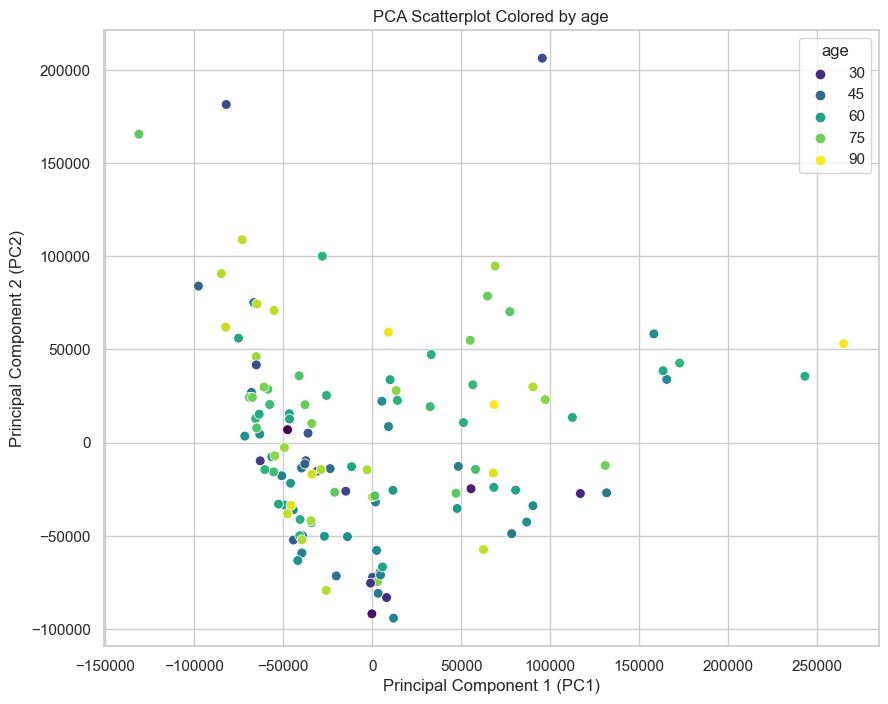

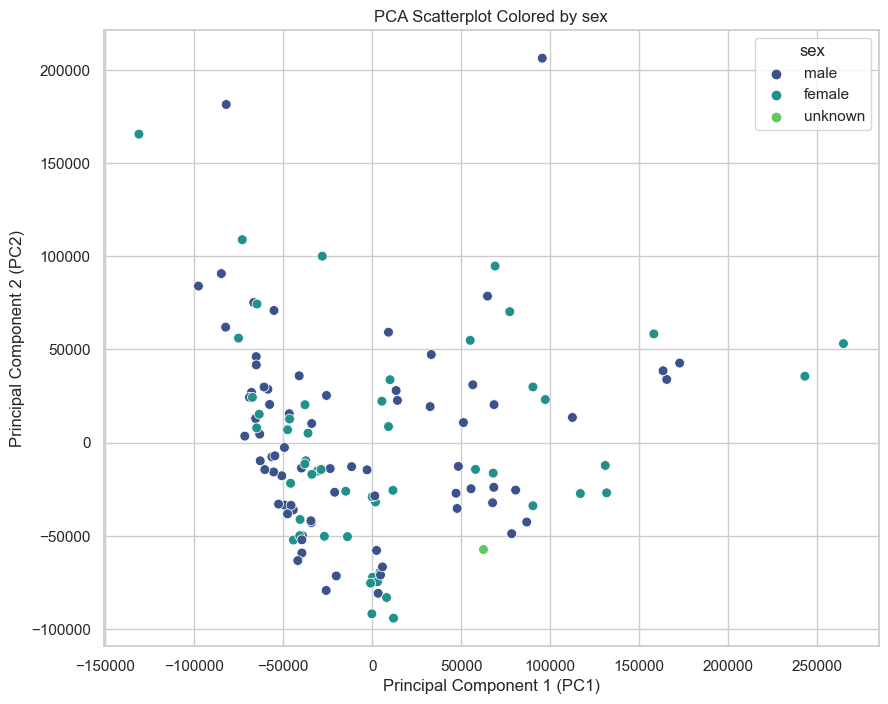

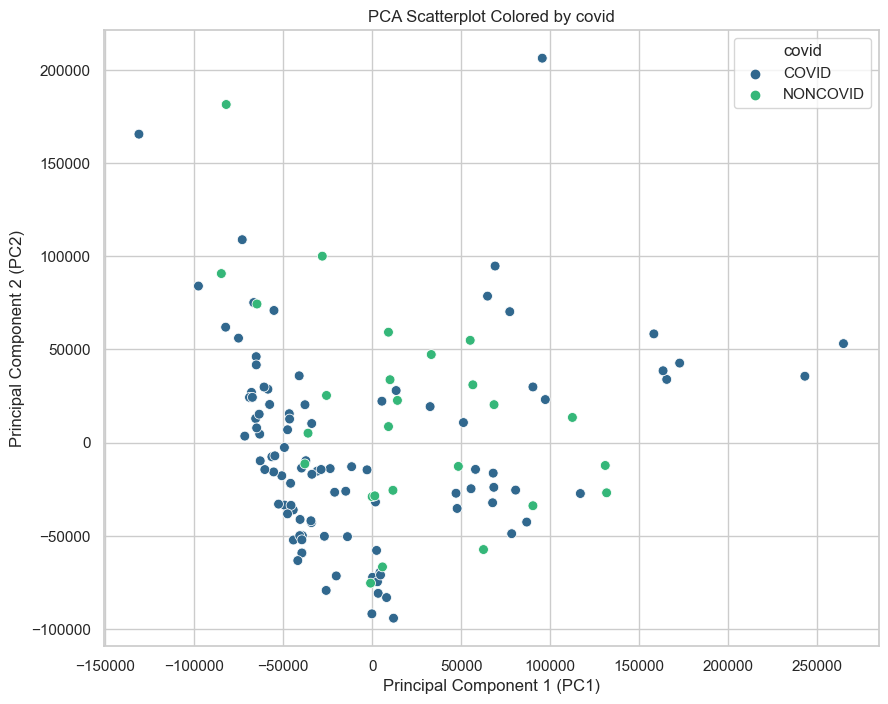

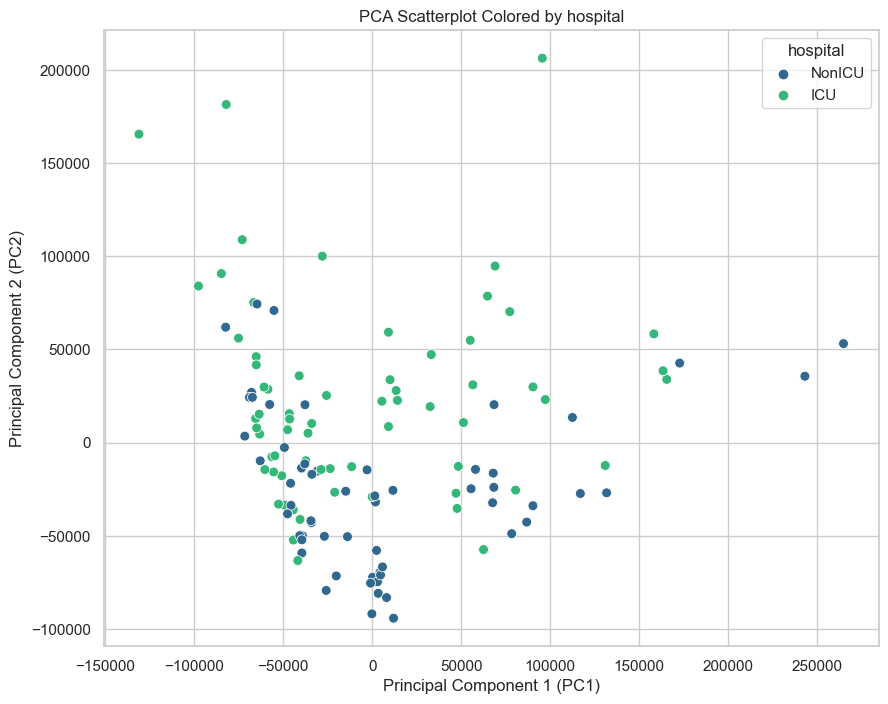

In [18]:
# PLOT HERE

# Load the metadata file
metadata_path = './GSE157103_metadata.csv'
metadata = pd.read_csv(metadata_path)

# Drop the unnamed column and convert 'age' to numeric, replacing ':' with NaN
metadata.drop(columns=['Unnamed: 0'], inplace=True)
metadata['age'] = pd.to_numeric(metadata['age'], errors='coerce')

# Load the counts data again for PCA
counts_path = './GSE157103_genes.tpm.tsv'
counts = pd.read_table(counts_path, sep='\t')
counts = counts.rename(columns={'#symbol': 'sampleID'}).set_index('sampleID').T

# Filter out genes with zero expression in more than 90% of samples
required_non_zero_samples = counts.shape[0] * 0.10
filtered_counts = counts.loc[:, (counts > 0).sum(axis=0) >= required_non_zero_samples]

# Perform PCA on the filtered counts data
pca = PCA(n_components=4)
pca_result = pca.fit_transform(filtered_counts)
pca_df = pd.DataFrame(pca_result, index=filtered_counts.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Merge the PCA results with metadata
merged_data = pca_df.join(metadata.set_index('sampleID'))

# Plot scatter plots for different metadata traits
traits_to_plot = ['age', 'sex', 'covid', 'hospital']
for trait in traits_to_plot:
    # Check if the trait exists in the metadata to avoid errors
    if trait in merged_data.columns:
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x='PC1', y='PC2', data=merged_data, hue=trait, palette='viridis', s=50)
        plt.title(f'PCA Scatterplot Colored by {trait}')
        plt.xlabel('Principal Component 1 (PC1)')
        plt.ylabel('Principal Component 2 (PC2)')
        plt.legend(title=trait)
        plt.show()


2. Do you see any trends in the PCA plots you generated?

*ANSWER HERE*

- Age: The plot does not seem to show a strong clustering by age, suggesting that the principal components may not be capturing variance specifically related to the age of the patients.
- Sex: Similarly, there is no distinct clustering by sex. The distribution of male, female, and unknown sex samples appears to be relatively even across the principal components.
- COVID Status: The scatterplot colored by COVID status (COVID vs. NONCOVID) also does not indicate clear separation based on the disease status. Both COVID and NONCOVID samples are interspersed throughout the PCA plot.
- Hospitalization: The plot does show some degree of clustering based on the hospitalization status (ICU vs. NonICU). While not definitive, there seems to be a slight trend where ICU samples are somewhat more scattered or possibly have a different spread in the PCA space compared to NonICU samples, which could reflect different patterns of gene expression associated with the severity of the disease.

3. Look at multiple PC's beyond PCs 1 and 2. Investigate PC's 3 and 4. Do you see any trends in these plots? What does this mean for the variation explained by these PCs?

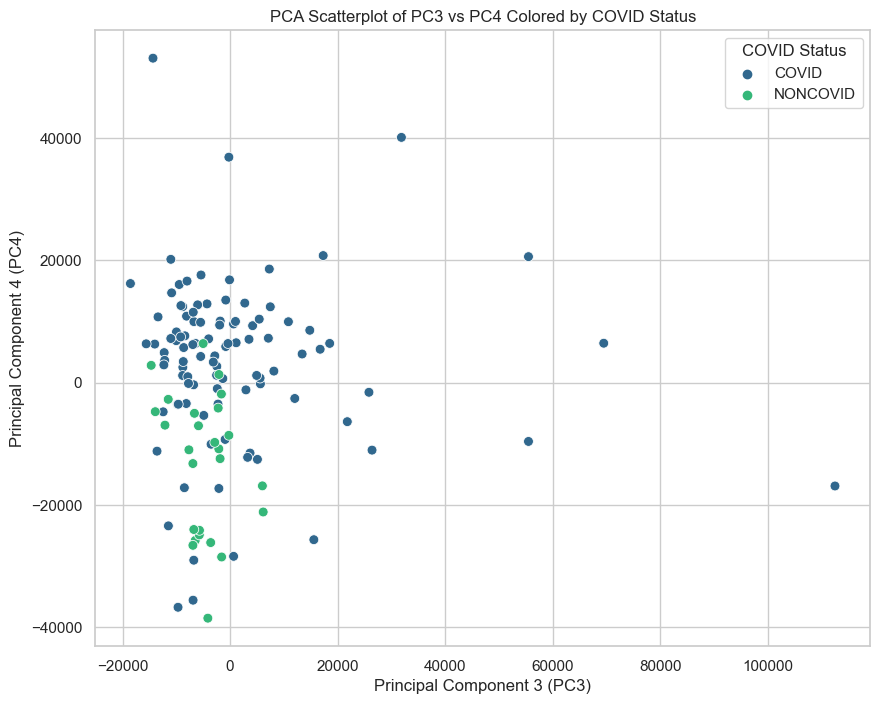

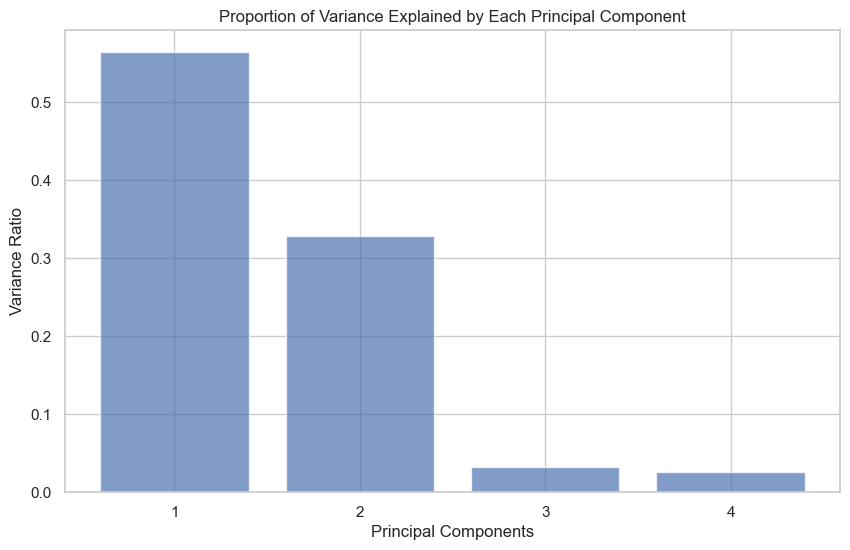

In [19]:
# PLOT HERE

metadata = pd.read_csv('./GSE157103_metadata.csv')

# Drop the unnamed column and convert 'age' to numeric, replacing ':' with NaN
metadata.drop(columns=['Unnamed: 0'], inplace=True)
metadata['age'] = pd.to_numeric(metadata['age'], errors='coerce')

# Perform PCA with 4 components on the filtered counts data
pca = PCA(n_components=4)
pca_result = pca.fit_transform(filtered_counts)
pca_df = pd.DataFrame(pca_result, index=filtered_counts.index,
                      columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Merge the PCA results with metadata
merged_data = pca_df.join(metadata.set_index('sampleID'))

# Investigate PCs 3 and 4 by plotting them with seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC3', y='PC4', data=merged_data, hue='covid', palette='viridis', s=50)
plt.title('PCA Scatterplot of PC3 vs PC4 Colored by COVID Status')
plt.xlabel('Principal Component 3 (PC3)')
plt.ylabel('Principal Component 4 (PC4)')
plt.legend(title='COVID Status')
plt.show()

# We will look at the proportion of variance explained by the PCs again
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.title('Proportion of Variance Explained by Each Principal Component')
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()


*ANSWER HERE*

1. PCA Scatterplot of PC3 vs PC4 Colored by COVID Status: From the PCA scatterplot of PC3 versus PC4, there does not seem to be a clear distinction between COVID and NONCOVID samples, indicating that these components do not capture variance directly associated with COVID status. The samples are intermixed, suggesting that PC3 and PC4 are capturing other forms of variation that are not distinctly related to whether the samples are from COVID or NONCOVID patients.
2. Proportion of Variance Explained by Each Principal Component: The variance explained by the principal components shows that PC1 explains the most variance, followed by PC2, which is a common pattern in PCA. PC3 and PC4 explain significantly less variance. This suggests that the most substantial variations within the data are captured by the first two components, while the third and fourth components capture progressively less variance and may represent more subtle or complex underlying patterns.

## 3: Other EDA

Ok cool. We were able to use PCA to identify directions of maximal variation in the data and use these to clean the data and find associations with genes and metadata information. Let's take a deeper look at certain aspects of the data.

#### a) Let's explore relationships between the metadata traits

1. Investigate the relationship between age and hospital status for patients with covid. Plot this relationship using histograms. Are certain ages more associated with ICU admittance than others?

In [22]:
# Load the CSV file
file_path = './GSE157103_metadata.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure and identify the relevant columns for analysis
df.head()

,Unnamed: 0,sampleID,age,sex,hospital,covid
0,0,C1,39,male,NonICU,COVID
1,1,C2,63,male,NonICU,COVID
2,2,C3,33,male,NonICU,COVID
3,3,C4,49,male,NonICU,COVID
4,4,C5,49,male,NonICU,COVID


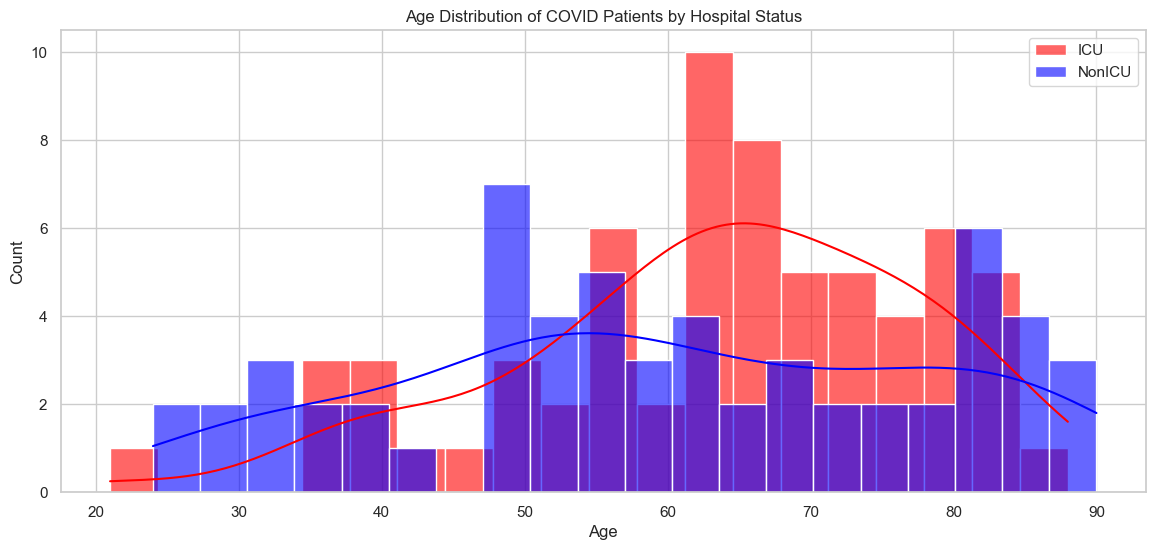

In [23]:
# PLOTS HERE

# Convert age to numeric, errors='coerce' will convert non-numeric values to NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Drop rows where age or hospital status is NaN, especially relevant if age conversion resulted in NaNs
df_clean = df.dropna(subset=['age', 'hospital'])

# Separate the dataframe into two based on hospital status: ICU vs NonICU
icu_df = df_clean[df_clean['hospital'] == 'ICU']
non_icu_df = df_clean[df_clean['hospital'] == 'NonICU']

# Plotting
plt.figure(figsize=(14, 6))

# Histogram for patients in ICU
sns.histplot(icu_df['age'], color='red', kde=True, label='ICU', bins=20, alpha=0.6)

# Histogram for patients not in ICU
sns.histplot(non_icu_df['age'], color='blue', kde=True, label='NonICU', bins=20, alpha=0.6)

plt.title('Age Distribution of COVID Patients by Hospital Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()


*ANSWER HERE*

Based on the graph, there is a visible difference in the age distribution of COVID patients admitted to the ICU compared to those not in the ICU. It seems that patients in the age range of approximately 60 to 80 years old are more frequently admitted to the ICU, as indicated by the red bars and curve. This trend could suggests that older adults are more likely to require intensive care, which is in line with general findings that older adults tend to be at higher risk for severe illness from COVID 19.

#### b) Genes of interest

1. In the paper, the authors highlight CD24 as a gene that is relevant. Plot the distribution of CD24 expression across the metadata traits (covid, hospital, sex, etc.). Do you see anything notable? What does CD24 do, and how could that be related to your observations?

In [25]:
gene_expression_file_path = './GSE157103_genes.tpm.tsv'
gene_expression_df = pd.read_csv(gene_expression_file_path, sep='\t')
gene_expression_df.head()

,#symbol,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,NC17,NC18,NC19,NC20,NC21,NC22,NC23,NC24,NC25,NC26
0,A1BG,0.49,0.29,0.26,0.45,0.17,0.21,0.49,0.12,0.51,...,0.37,0.33,0.25,0.20,0.40,0.30,0.70,0.75,2.80,0.22
1,A1CF,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,A2M,0.21,0.14,0.03,0.09,0.00,0.08,0.23,0.08,0.88,...,0.07,0.06,0.11,0.01,0.04,0.02,0.02,0.27,0.04,0.28
3,A2ML1,0.04,0.00,0.02,0.07,0.05,0.04,0.03,0.01,0.02,...,0.01,0.00,0.00,0.02,0.02,0.02,0.01,0.00,0.00,0.00
4,A3GALT2,0.07,0.00,0.00,0.00,0.07,0.00,0.07,0.00,0.79,...,0.18,0.00,0.04,0.00,0.00,0.00,0.00,0.06,0.00,0.00


In [29]:
# Normalize the gene symbol column for comparison
gene_expression_df['#symbol'] = gene_expression_df['#symbol'].str.strip().str.upper()

# Find the row for the CD24 gene
cd24_expression = gene_expression_df[gene_expression_df['#symbol'] == 'CD24']

if not cd24_expression.empty:
    # Reshape the data
    cd24_expression = cd24_expression.melt(id_vars=['#symbol'], var_name='sampleID', value_name='CD24_expression')
    cd24_expression.drop('#symbol', axis=1, inplace=True)
    cd24_expression.head()
else:
    cd24_expression = None
    print("CD24 gene not found in the expression dataset. Please check the dataset for the correct gene symbol.")

cd24_expression.head()

,sampleID,CD24_expression
0,C1,9.51
1,C2,138.34
2,C3,14.29
3,C4,31.38
4,C5,7.95


In [30]:
metadata_file_path = './GSE157103_metadata.csv'
metadata_df = pd.read_csv(metadata_file_path)
merged_df = pd.merge(metadata_df, cd24_expression, on='sampleID')
merged_df.head()


,Unnamed: 0,sampleID,age,sex,hospital,covid,CD24_expression
0,0,C1,39,male,NonICU,COVID,9.51
1,1,C2,63,male,NonICU,COVID,138.34
2,2,C3,33,male,NonICU,COVID,14.29
3,3,C4,49,male,NonICU,COVID,31.38
4,4,C5,49,male,NonICU,COVID,7.95


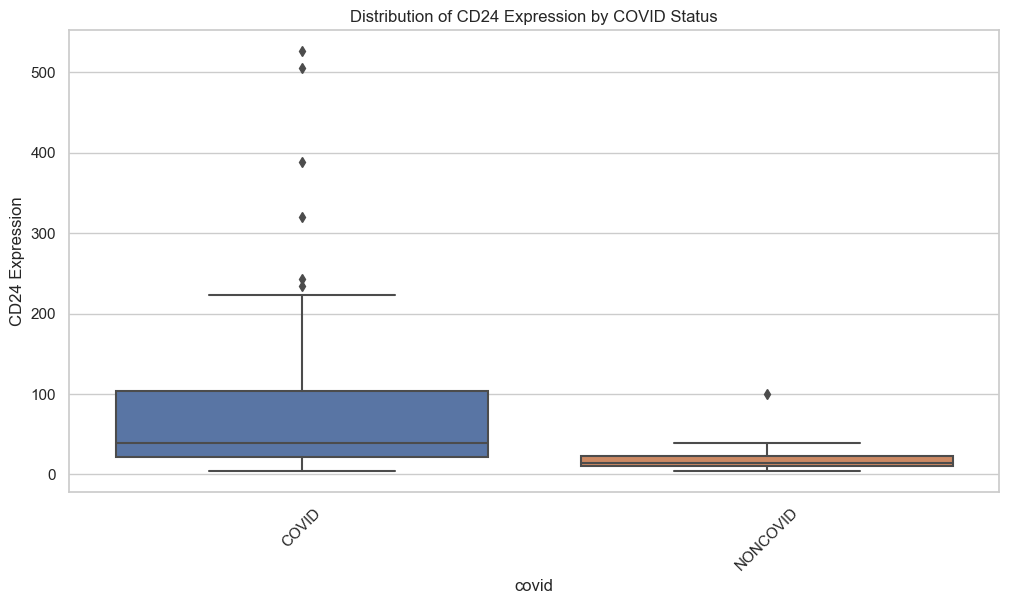

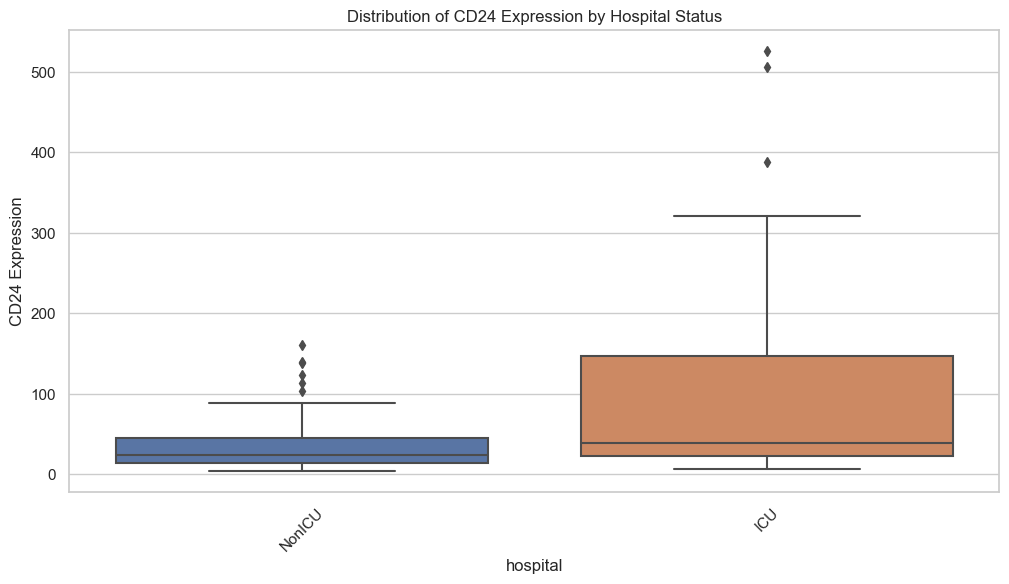

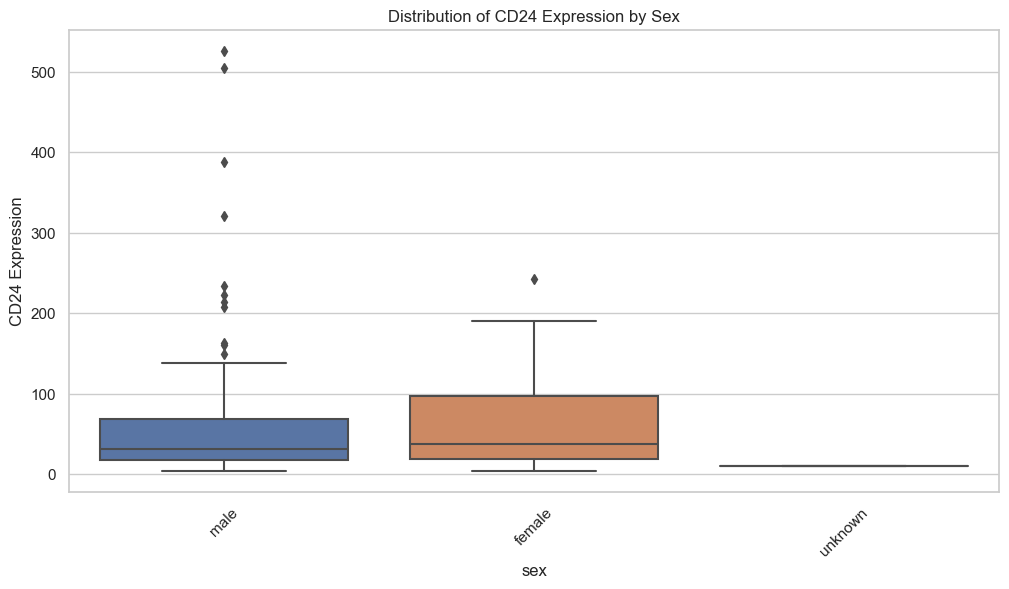

In [31]:
# PLOTS HERE

# Define a function to plot the distribution for a given trait
def plot_cd24_distribution(data, trait, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=trait, y='CD24_expression', data=data)
    plt.title(title)
    plt.ylabel('CD24 Expression')
    plt.xlabel(trait)
    plt.xticks(rotation=45)
    plt.show()

# Plotting
plot_cd24_distribution(merged_df, 'covid', 'Distribution of CD24 Expression by COVID Status')
plot_cd24_distribution(merged_df, 'hospital', 'Distribution of CD24 Expression by Hospital Status')
plot_cd24_distribution(merged_df, 'sex', 'Distribution of CD24 Expression by Sex')


*ANSWER HERE*

- COVID vs. Non-COVID Patients: The boxplot shows a higher median and range of CD24 expression in COVID patients compared to non-COVID patients. This suggests that CD24 may be upregulated in the presence of a COVID infection, which could be related to the immune response or the pathophysiology of the disease.
- Hospital Status (ICU vs. Non-ICU Patients): Patients in the ICU have a wider range and slightly higher median expression of CD24 than non-ICU patients. This could indicate that CD24 is associated with the severity of the disease, as ICU patients typically have more severe symptoms.
- Sex (Male vs. Female): The expression of CD24 appears to be higher in females compared to males, as shown by both the median and the interquartile range of the boxplot. This could point to sex-specific differences in the immune response or disease progression.

CD24 is a cell surface protein involved in a variety of processes including cell adhesion and immune response. Its role in immune response regulation could explain the observed variations in expression related to COVID 19 infection, as the immune system is critically involved in the body's response to viral infections. Also, the observed differences in CD24 expression could reflect how individuals’ immune systems react to the infection, which could impact the disease severity and progression.

In our observations, CD24 could potentially be used as a biomarker for COVID 19 infection serverity and may offer something notable of the biological mechanisms underlying the differences in disease outcomes among patients.


#### c) Bootstrapping and Multiple Hypothesis Testing

1. The paper also identified LCN2 as a gene that is differentially expressed in COVID patients. LCN2 is an protein involved in innate immune response. We want to see if expression of this gene changes based on covid status. To start, plot LCN2 expression vs covid status.

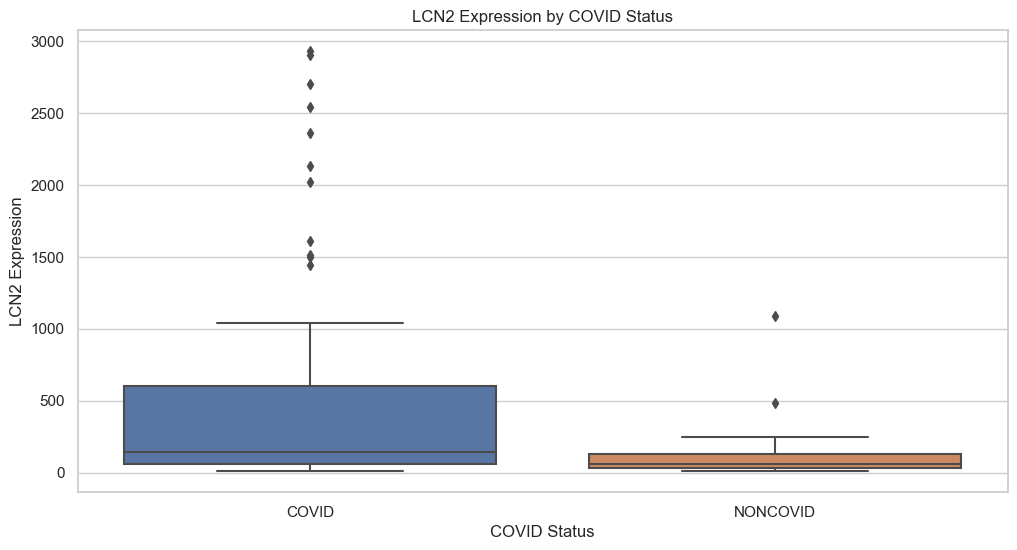

In [32]:
# PLOT HERE

# Identify the LCN2 gene
lcn2_expression = gene_expression_df[gene_expression_df['#symbol'] == 'LCN2']

if not lcn2_expression.empty:
    # Reshape the data
    lcn2_expression = lcn2_expression.melt(id_vars=['#symbol'], var_name='sampleID', value_name='LCN2_expression')
    lcn2_expression.drop('#symbol', axis=1, inplace=True)
    # Merge the LCN2 expression data with the metadata
    merged_lcn2_df = pd.merge(metadata_df, lcn2_expression, on='sampleID')
    # Plot the LCN2 expression vs. COVID status
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='covid', y='LCN2_expression', data=merged_lcn2_df)
    plt.title('LCN2 Expression by COVID Status')
    plt.ylabel('LCN2 Expression')
    plt.xlabel('COVID Status')
    plt.show()
else:
    print("Not found")


2. These two distributions look pretty different. But we want to see if they are actually significantly different or not. Let's do a bootstrap test. First, generate 1000 bootstrap samples of LCN2 expression for covid and noncovid groups by sampling with replacement. Plot the distributions of our bootstrapped sample means.

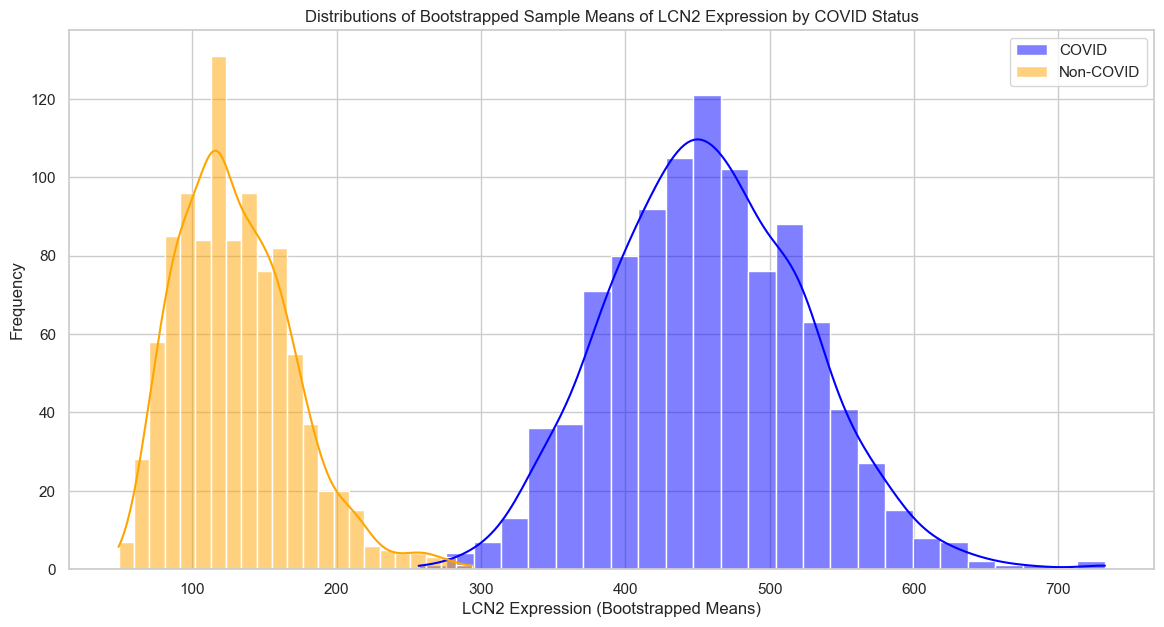

In [40]:
# PLOT HERE

# Correct the COVID status in the metadata and re-separate the LCN2 expression
merged_lcn2_df['covid'] = merged_lcn2_df['covid'].replace({'nonCOVID': 'NONCOVID'})
covid_lcn2_expression = merged_lcn2_df[merged_lcn2_df['covid'] == 'COVID']['LCN2_expression'].values
noncovid_lcn2_expression = merged_lcn2_df[merged_lcn2_df['covid'] == 'NONCOVID']['LCN2_expression'].values

# Define the number of bootstrap samples
n_bootstraps = 1000

# Function to generate bootstrap samples
def bootstrap_samples(data, n):
    return np.random.choice(data, replace=True, size=(n, len(data)))

# Generate bootstrap samples for each group
bootstrap_samples_covid = bootstrap_samples(covid_lcn2_expression, n_bootstraps)
bootstrap_samples_noncovid = bootstrap_samples(noncovid_lcn2_expression, n_bootstraps)

# Calculate the means of the bootstrap samples for each group
bootstrap_means_covid = np.mean(bootstrap_samples_covid, axis=1)
bootstrap_means_noncovid = np.mean(bootstrap_samples_noncovid, axis=1)

# Plotting the distributions of the bootstrap sample means
plt.figure(figsize=(14, 7))

sns.histplot(bootstrap_means_covid, color='blue', label='COVID', kde=True)
sns.histplot(bootstrap_means_noncovid, color='orange', label='Non-COVID', kde=True)

plt.xlabel('LCN2 Expression (Bootstrapped Means)')
plt.ylabel('Frequency')
plt.title('Distributions of Bootstrapped Sample Means of LCN2 Expression by COVID Status')
plt.legend()
plt.show()


3. Next, calculate a 95% confidence interval using a test statistic for each sample. Is the expression of CD24 between these groups significantly different? In other words, do their confidence intervals overlap? In addition, calculate p-values by counting the number of times the COVID mean is less than the non-COVID mean.

Use the following formula: `CI = sample mean +/- test_statistic*sample standard deviation`

In [41]:
# PLOT HERE

from scipy import stats

# Calculate the z-score for a 95% confidence interval
z_score = stats.norm.ppf(1 - (1 - 0.95) / 2)

# Calculate the mean and standard deviation of the bootstrapped means
mean_covid = np.mean(bootstrap_means_covid)
std_covid = np.std(bootstrap_means_covid)

mean_noncovid = np.mean(bootstrap_means_noncovid)
std_noncovid = np.std(bootstrap_means_noncovid)

# Calculate the 95% confidence interval for each group
ci_covid = (mean_covid - z_score * std_covid, mean_covid + z_score * std_covid)
ci_noncovid = (mean_noncovid - z_score * std_noncovid, mean_noncovid + z_score * std_noncovid)

# Calculate the p-value by counting how often the mean of the COVID group is less than the mean of the non-COVID group
p_value = np.mean(bootstrap_means_covid < bootstrap_means_noncovid)

# Display the results
print(f"95% Confidence Interval for COVID group: {ci_covid}")
print(f"95% Confidence Interval for Non-COVID group: {ci_noncovid}")
print(f"P-value: {p_value}")

# Check if confidence intervals overlap
overlap = not (ci_covid[1] < ci_noncovid[0] or ci_noncovid[1] < ci_covid[0])
print(f"Do the confidence intervals overlap? {'Yes' if overlap else 'No'}")


95% Confidence Interval for COVID group: (324.2478451454713, 590.1039096545287)
95% Confidence Interval for Non-COVID group: (51.13327789271075, 209.0586990303662)
P-value: 0.0
Do the confidence intervals overlap? No


*ANSWER HERE*

The confidence intervals do not overlap, indicating that the difference in LCN2 expression between COVID and non-COVID groups is statistically significant.

Additionally, the p-value is 0.0, which means that in our bootstrap samples, the mean expression of LCN2 in the COVID group was never less than the mean expression in the non-COVID group. This further supports the conclusion that the expression of LCN2 is significantly different between these two groups.

4. In addition to CD24 and LCN2, the paper found many genes for which COVID results in increased expression. Let's try to find some of these genes. Perform a bootstrap test like above for the 200 genes below and find their p-values.

In [49]:
# Use the following genes for your bootstrap test
genes = np.array(['WDR33', 'ARHGAP9', 'GASK1B', 'RNF182', 'PTPRO', 'HIVEP2', 'ENOX1','TIPIN', 'R3HDM1', 'ZBTB3', 'METTL18', 'C1orf116', 'APOC1','CDHR5', 'GAB3', 'FGFBP3', 'HSBP1', 'HPS3', 'MRPS10', 'CHST11','ACSM6', 'CNTROB', 'CALCOCO2', 'BACH2', 'RAB2A', 'DAPP1', 'DNAH12','MUS81', 'TMED1', 'PM20D2', 'MTMR2', 'PLEKHG2', 'PFKFB1', 'MINDY2','PEX12', 'PRMT2', 'CFAP161', 'WDR19', 'RSPH3', 'MDC1', 'TMEM131L','CPA4', 'C12orf4', 'DNAJC9', 'ASH2L', 'RCE1', 'PPFIA4', 'SORT1','MAFF', 'ODR4', 'SLC29A2', 'IRF7', 'GOLGA6D', 'ACOT9', 'EIF2S1','ASB1', 'RARS2', 'LIPE', 'ASF1A', 'MOCOS', 'NHS', 'RRP15','HNRNPA2B1', 'MPLKIP', 'KIF17', 'FUZ', 'ZNF525', 'ZNF134', 'MAGI3','CEP250', 'CBFB', 'CHI3L1', 'UBXN4', 'FUBP3', 'IL6ST', 'AGPAT5','TACSTD2', 'SGCE', 'GRK4', 'DAZAP1', 'HECTD2', 'MGST2', 'SLC39A1','TUBGCP2', 'CDK4', 'RIMKLA', 'TAPT1', 'PRF1', 'OR2T8', 'FGFR4','TRAIP', 'MAPK9', 'STK3', 'ALG13', 'ITGA8', 'SH2B1', 'ACTR1B','XRCC3', 'MTARC1', 'SCARB1', 'TNNI1', 'LHB', 'HOXB3', 'C1RL','ATE1', 'ZMYND12', 'PAF1', 'PPIB', 'PPTC7', 'OR5K2', 'ZNF296','PTPMT1', 'CHGA', 'SYN3', 'DCUN1D3', 'ZFYVE16', 'PDLIM4', 'PEX11A','VPS45', 'RALGPS2', 'BBS7', 'INHBE', 'NR1H3', 'LDHD', 'GINS2','DGCR2', 'SPIN3', 'ANKS6', 'CASP6', 'MAGEA8', 'CSNK1G2', 'STRBP','IFNK', 'RCC1', 'C17orf80', 'FAM153A', 'TMEM145', 'SUN3','ARHGAP42', 'GRAMD2B', 'KRT15', 'SYNPO', 'GPR179', 'FBXL6','ACTN3', 'RABGGTA', 'SH2D1A', 'EMCN', 'CD38', 'MAGI1', 'LRGUK','ACTG2', 'CAMKV', 'RGS2', 'TRNAU1AP', 'NLRX1', 'RBL2', 'VPS4A','CKS2', 'TENT4B', 'IDO2', 'CASC3', 'METTL8', 'RAB3D', 'CLSPN','C2CD6', 'MRPS24', 'GPM6A', 'CDC37', 'PRSS41', 'FAM151B', 'C7orf31', 'MATN2', 'MARCHF1', 'IGFALS', 'TESC', 'TMC1', 'ZNF784','TAZ', 'NEU1', 'ZNF41', 'RIMBP3B', 'SLC9A5', 'CBX7', 'GCDH','TMEM18', 'KDR', 'PFDN1', 'KRT38', 'P2RX6', 'TSPAN17', 'ATP6V0B','EPX', 'HLF', 'RRP1', 'SLC16A2', 'GJA1', 'NUPR1', 'USP8', 'CEP128'])
print(len(genes))

200


In [47]:
# CODE HERE

# Perform bootstrap test and return the p-value for a single gene
def bootstrap_test(gene_expression, n_bootstraps, covid_expression, noncovid_expression):
    bootstrap_samples_covid = bootstrap_samples(covid_expression, n_bootstraps)
    bootstrap_samples_noncovid = bootstrap_samples(noncovid_expression, n_bootstraps)

    bootstrap_means_covid = np.mean(bootstrap_samples_covid, axis=1)
    bootstrap_means_noncovid = np.mean(bootstrap_samples_noncovid, axis=1)
    
    # P-value is the proportion of times non-covid mean is greater than covid mean
    p_value = np.mean(bootstrap_means_noncovid > bootstrap_means_covid)
    return p_value

# List to hold the p-values
p_values = []

# Iterate over the list of genes and perform the bootstrap test for each
for gene in genes:
    gene_expression = gene_expression_df[gene_expression_df['#symbol'] == gene]
    if not gene_expression.empty:
        # Reshape the data
        gene_expression = gene_expression.melt(id_vars=['#symbol'], var_name='sampleID', value_name=f'{gene}_expression')
        gene_expression.drop('#symbol', axis=1, inplace=True)
        # Merge with metadata
        merged_gene_df = pd.merge(metadata_df, gene_expression, on='sampleID')
        # Separate expression based on COVID status
        covid_expression = merged_gene_df[merged_gene_df['covid'] == 'COVID'][f'{gene}_expression'].values
        noncovid_expression = merged_gene_df[merged_gene_df['covid'] == 'NONCOVID'][f'{gene}_expression'].values
        # Perform the bootstrap test
        p_value = bootstrap_test(gene_expression, n_bootstraps, covid_expression, noncovid_expression)
        p_values.append((gene, p_value))
    else:
        p_values.append((gene, np.nan)) # NaN if gene not found

p_values_dict = dict(p_values)
p_values_dict


{'WDR33': 0.0,
 'ARHGAP9': 0.244,
 'GASK1B': 0.003,
 'RNF182': 0.184,
 'PTPRO': 0.037,
 'HIVEP2': 0.0,
 'ENOX1': 0.69,
 'TIPIN': 0.0,
 'R3HDM1': 0.0,
 'ZBTB3': 0.0,
 'METTL18': 0.007,
 'C1orf116': nan,
 'APOC1': 0.411,
 'CDHR5': 0.868,
 'GAB3': 0.003,
 'FGFBP3': 0.573,
 'HSBP1': 0.316,
 'HPS3': 0.0,
 'MRPS10': 0.0,
 'CHST11': 0.0,
 'ACSM6': 0.0,
 'CNTROB': 0.002,
 'CALCOCO2': 0.0,
 'BACH2': 0.062,
 'RAB2A': 0.001,
 'DAPP1': 0.0,
 'DNAH12': 0.016,
 'MUS81': 0.308,
 'TMED1': 0.986,
 'PM20D2': 0.0,
 'MTMR2': 0.0,
 'PLEKHG2': 0.002,
 'PFKFB1': 0.009,
 'MINDY2': 0.0,
 'PEX12': 0.006,
 'PRMT2': 0.254,
 'CFAP161': 0.0,
 'WDR19': 0.0,
 'RSPH3': 0.0,
 'MDC1': 0.0,
 'TMEM131L': 0.0,
 'CPA4': 0.341,
 'C12orf4': nan,
 'DNAJC9': 0.0,
 'ASH2L': 0.0,
 'RCE1': 0.649,
 'PPFIA4': 0.037,
 'SORT1': 0.098,
 'MAFF': 0.002,
 'ODR4': 0.0,
 'SLC29A2': 0.824,
 'IRF7': 0.044,
 'GOLGA6D': 0.017,
 'ACOT9': 0.0,
 'EIF2S1': 0.0,
 'ASB1': 0.005,
 'RARS2': 0.0,
 'LIPE': 0.791,
 'ASF1A': 0.007,
 'MOCOS': 0.0,
 'NHS': 0

5. Use Benjamini Hochberg FDR multiple hypothesis correction to adjust the p-values from the last section for the number of hypothesis tests performed. Without using the correction, with an alpha of 0.05, how many genes were significantly differentially expressed? With the correction, how many genes were significantly differentially expressed?

In [48]:
# CODE HERE

from statsmodels.stats.multitest import multipletests

# Perform bootstrap test and return the p-value for a single gene
def bootstrap_test(gene_expression, n_bootstraps, covid_expression, noncovid_expression):
    bootstrap_samples_covid = bootstrap_samples(covid_expression, n_bootstraps)
    bootstrap_samples_noncovid = bootstrap_samples(noncovid_expression, n_bootstraps)

    bootstrap_means_covid = np.mean(bootstrap_samples_covid, axis=1)
    bootstrap_means_noncovid = np.mean(bootstrap_samples_noncovid, axis=1)
    
    # P-value is the proportion of times non-covid mean is greater than covid mean
    p_value = np.mean(bootstrap_means_noncovid > bootstrap_means_covid)
    return p_value

# List to hold the p-values
p_values = []

# Iterate over the list of genes and perform the bootstrap test for each
for gene in genes:
    gene_expression = gene_expression_df[gene_expression_df['#symbol'] == gene]
    if not gene_expression.empty:
        # Reshape the data
        gene_expression = gene_expression.melt(id_vars=['#symbol'], var_name='sampleID', value_name=f'{gene}_expression')
        gene_expression.drop('#symbol', axis=1, inplace=True)
        # Merge with metadata
        merged_gene_df = pd.merge(metadata_df, gene_expression, on='sampleID')
        # Separate expression based on COVID status
        covid_expression = merged_gene_df[merged_gene_df['covid'] == 'COVID'][f'{gene}_expression'].values
        noncovid_expression = merged_gene_df[merged_gene_df['covid'] == 'NONCOVID'][f'{gene}_expression'].values
        # Perform the bootstrap test
        p_value = bootstrap_test(gene_expression, n_bootstraps, covid_expression, noncovid_expression)
        p_values.append(p_value)
    else:
        p_values.append(np.nan) # NaN if gene not found

# Apply Benjamini-Hochberg correction
p_adjusted = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

# Number of significant genes without correction
significant_genes_uncorrected = sum(np.array(p_values) < 0.05)

# Number of significant genes with correction
significant_genes_corrected = sum(p_adjusted < 0.05)

(significant_genes_uncorrected, significant_genes_corrected)


(111, 0)

*ANSWER HERE*

- Before applying the Benjamini-Hochberg FDR multiple hypothesis correction, with an alpha of 0.05, 111 genes were considered significantly differentially expressed.
- Also, after applying the correction, 0 genes were found to be significantly differentially expressed.

## 4: Future Directions

#### a) After this EDA, what kind of relationships do you think are worth studying in more detail?

*ANSWER HERE*

1. Gene Expression and Disease Severity: The initial analysis indicated potential differences in gene expression between patients admitted to the ICU and those not requiring ICU care. This relationship merits deeper investigation to identify genes that could predict disease severity and outcomes, which is crucial for patient management and treatment planning
2. Association with Other Clinical Variables: Beyond gene expression, the relationship between clinical variables (e.g., comorbidities, age, and treatment received) and COVID-19 outcomes could provide a holistic understanding of the disease. Integrating genomic data with clinical data can help identify high-risk patient profiles and tailor treatment approaches.
3. Multiple Gene Interactions: While the focus was on individual genes like CD24 and LCN2, the interactions between multiple genes and their collective impact on COVID-19 infection and severity are also worth exploring. Network analysis and pathway analysis could uncover complex biological processes affected by COVID-19.

#### b) What kind of data or questions would you want to look into more in the future?

*ANSWER HERE*

1. The first one would single-cell RNA sequencing data, so we can ask questions like "How does COVID 19 affect different cell types within the human body?" since these type of data can reveal cell-type-specific responses to infection, uncovering mechanisms of tissue damage, immune responses, and potential targets for therapy.
2. Also, comparative genomics: "How do genetic differences between SARS-CoV-2 strains affect virulence, transmissibility, and vaccine effectiveness?"
3. How does genetic diversity among humans affect the immune response to COVID-19 vaccines, and what are the genetic correlates of protection or adverse reactions?
4. How do variations in human behavior and compliance with public health interventions in different cultural or demographic contexts influence the effectiveness of strategies aimed at suppressing SARS-CoV-2 indoor transmission? (which is my ongoing research now!)


## The end.